#CS6910: Deep Learning - Assignment 1

Shibobrota Das (CS20M059) | Abhishek Kumar (CS20M007)

In [ ]:
!pip install wandb -qqq
import wandb
wandb.init(project='Assignment 1', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20m059 (use `wandb login --relogin` to force relogin)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from scipy.special import expit, softmax
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
(train_x, train_y), (test_x, test_y)= fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Load Dataset from fashion_mnist and log one sample from each set

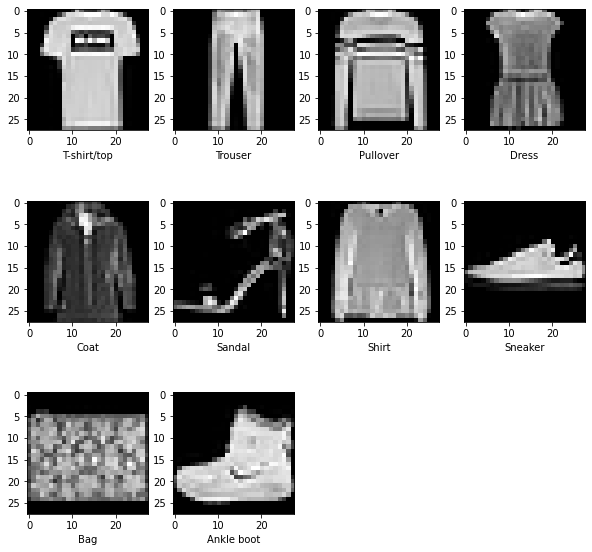

In [ ]:
class_values, unique_indices = np.unique(train_y, return_index=True)
plt.figure(figsize=(10,10))
labelled_images = {}
for d in range(10):
  plt.subplot(3, 4, d+1)
  plt.imshow(train_x[unique_indices[d]], cmap=plt.get_cmap('gray'))
  plt.xlabel(classes[class_values[d]])
  labelled_images[classes[class_values[d]]] = train_x[unique_indices[d]]
plt.show()

In [ ]:
wandb.log({"A1-Examples": [wandb.Image(img, caption=cap) for cap,img in labelled_images.items()]})

#Implemention of feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

In [ ]:
#Reshape 2D Matrix into 1D Vector
train_x = np.array(train_x.reshape(len(train_x), 28 ** 2, 1))
test_x = np.array(test_x.reshape(len(test_x), 28 ** 2, 1))

#Normalizing data
train_x = train_x/255.0
test_x = test_x/255.0

#Splitting Data
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, train_size = 0.9, test_size = 0.1)

In [ ]:
#Activation function Def

def relu(z):
  return x * (x > 0)                                           #learnt from https://stackoverflow.com/questions/32109319/how-to-implement-the-relu-function-in-numpy

def sigmoid(z):
  return expit(z)

def tanh(z):
  return np.tanh(z)


#Activation function derivative Def

def grad_tanh(x):
  return 1-(tanh(x) ** 2)

def grad_sigmoid(x):
  sig_x = sigmoid(x)
  return sig_x*(1-sig_x)

def grad_relu(x):
  temp = 1. * (x > 0)                                          #learnt from https://stackoverflow.com/questions/32109319/how-to-implement-the-relu-function-in-numpy
  return temp

In [ ]:
#Type Initialization
RANDOM = "random"
XAVIER = "xavier"
ZEROES = "zeroes"

#Definitions

def init_weights(type: str, layers):
    W = {}
    for i in range(1, len(layers)):
      if type == RANDOM:
        W[i] = np.random.normal(0, 0.5, size=(layers[i], layers[i-1]))
      elif type == XAVIER:
        W[i] = np.random.uniform(-(1/np.sqrt(layers[i])), (1/np.sqrt(layers[i])), size=(layers[i], layers[i-1]))
      else:
        W[i] = np.zeros((layers[i], layers[i-1]))
    return W

def init_bias(type: str, layers):
    B = {}
    for i in range(1, len(layers)):
      if type == RANDOM:
        B[i] = np.random.randn(layers[i], 1)
      else:
        B[i] = np.zeros((layers[i], 1))
    return B

def init_params(type: str, layers):
  return init_weights(type, layers), init_bias(type, layers)

In [ ]:
#Type Initialization
SIGMOID = "sigmoid"
TAN_H = "tanh"
RELU = "relu"

#Definitions

def grad(activation: str, pre_act_vector):
  #increase precision
  pre_act_vector = np.array(pre_act_vector,dtype=np.longdouble)
  if activation == TAN_H:
    return grad_tanh(pre_act_vector)
  elif activation == SIGMOID:
    return grad_sigmoid(pre_act_vector)
  elif activation == RELU:
    return grad_relu(pre_act_vector)
  return None

def activate(activation: str, pre_act_vector):
  #increase precision
  pre_act_vector = np.array(pre_act_vector,dtype=np.longdouble)
  if activation == TAN_H:
    return tanh(pre_act_vector)
  elif activation == SIGMOID:
    return sigmoid(pre_act_vector)
  elif activation == RELU:
    return relu(pre_act_vector)
  return None

def cross_entropy_loss(label, y_hat):
  return - np.log(y_hat[label][0])

def squared_error_loss(label, y_hat):
  Y = np.array([1 if i == label else 0 for i in range(len(y_hat))]).reshape(np.shape(y_hat))
  loss = (Y - y_hat) ** 2
  return np.average(loss)

#Algorithm: Forward Propagation

In [ ]:
#Forward Propagation

def forward_propagation(data, activation, W, B, layers):                         
  H = {0:data}
  A = {}
  L = len(layers)-1
  for k in range(1, L):
    A[k] = np.matmul(W[k],H[k-1])+B[k]
    H[k] = activate(SIGMOID, A[k])
    
  A[L] = np.matmul(W[L],H[L-1])+B[L]
  y_hat = softmax(A[L])
  
  return H, A, y_hat

#Algorithm: Back Propagation

In [ ]:
def back_propagation(y, y_hat, A, H, W, layers, activation):
  Y = np.array([1 if i == y else 0 for i in range(len(y_hat))]).reshape(np.shape(y_hat))
  dW, dB = init_params(ZEROES, layers)
  dA = init_bias(ZEROES, layers)
  dH = init_bias(ZEROES, layers)
  L = len(layers) - 1
  dA[L] = -(Y - y_hat)
  for i in range(L, 0, -1):
    dW[i] = np.dot(dA[i], H[i - 1].T)
    dB[i] = dA[i]
    if i > 1:
      dH[i - 1] = np.dot(W[i].T, dA[i])
      dA[i - 1] = np.multiply(dH[i - 1], grad(activation, A[i - 1]))
  return dW, dB

#Momentum Based Gradient Descent

In [ ]:
#Vanilla Momentum Gradient Descent

def momentum(data,label,activation,epochs,layers,eta,init_type, logger_prefix = ""):

  gamma = 0.9
  W, B = init_params(init_type, layers)
  v_W, v_B = init_params(ZEROES, layers)
  dW, dB = init_params(ZEROES, layers)
  priv_W, priv_B = init_params(ZEROES, layers)
  L = len(layers) - 1
  counter, ce, se = 0, 0, 0
  loss_list = {"CE": [], "SE": [], "ACC":[]}
  accuracy = 0
  prediction_data = {"P":[], "A":[]}

  for n in range(epochs):
    if n > 0:
      data, label = shuffle(data, label)
    for k in range(len(data)):
      H, A, y_hat = forward_propagation(data[k], activation, W, B, layers)
      w, b = back_propagation(label[k],y_hat,A,H,W,layers,activation)
      for i in range(1, L+1):
        dW[i] += w[i]
        dB[i] += b[i]

      tem = np.argmax(y_hat, axis=0)[0]
      prediction_data['P'].append(tem)
      prediction_data["A"].append(label[k])
      if tem == label[k]:
        accuracy += 1
      counter += 1
    #Calculate and apply Momentum  
    for i in range(1, L+1):
      v_W[i] = gamma * priv_W[i] + eta * dW[i]
      v_B[i] = gamma * priv_B[i] + eta * dB[i]
      W[i] -= v_W[i]
      B[i] -= v_B[i]
    priv_W = v_W
    priv_B = v_B
    dW, dB = init_params(ZEROES, layers)
    ce = cross_entropy_loss(label[k], y_hat)
    se = squared_error_loss(label[k], y_hat)
    acc = accuracy/counter
    loss_list["CE"].append(ce)
    loss_list["SE"].append(se)
    loss_list["ACC"].append(acc)
    # print("Accuracy", acc)
    # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})
    
    print("Epoch", n,"Accuracy", accuracy/counter)
  return W, B, prediction_data

#Nesterov Accelerated Gradient Descent (NAG)


In [ ]:
#Nesterov Accelerated Gradient Descent (Minibatch)

def nag(data,label,activation,epochs,layers,eta,init_type,batch_size=1, logger_prefix = ""):

  gamma = 0.9
  W, B = init_params(init_type, layers)
  v_W, v_B = init_params(ZEROES, layers)
  dW, dB = init_params(ZEROES, layers)
  priv_W, priv_B = init_params(ZEROES, layers)
  L = len(layers) - 1
  counter, ce, se = 0, 0, 0
  loss_list = {"CE": [], "SE": [], "ACC":[]}
  accuracy = 0
  prediction_data = {"P":[], "A":[]}

  for n in range(epochs):
    if n > 0:
      data, label = shuffle(data, label)
    for b in range(0, len(data), batch_size):
      batch_data = data[b: b + batch_size]
      batch_label = label[b: b + batch_size]

      #Look Ahead calculation
      for i in range(1, L+1):
        v_W[i] = gamma * priv_W[i]
        v_B[i] = gamma * priv_B[i]
        W[i] -= v_W[i]
        B[i] -= v_B[i]

      for k in range(len(batch_data)):
        #Forward
        H, A, y_hat = forward_propagation(batch_data[k], activation, W, B, layers)
        #Backward
        w_g, b_g = back_propagation(batch_label[k],y_hat,A,H,W,layers,activation)
        for i in range(1, L+1):
          dW[i] += w_g[i]
          dB[i] += b_g[i]

        #Calc Accuracy
        tem = np.argmax(y_hat, axis=0)[0]
        prediction_data['P'].append(tem)
        prediction_data["A"].append(label[k])
        predictions = tem
        if tem == batch_label[k]:
          accuracy += 1
        counter += 1

      for i in range(1, L+1):
        v_W[i] = gamma * priv_W[i] + eta * dW[i]
        v_B[i] = gamma * priv_B[i] + eta * dB[i]
        W[i] -= v_W[i]
        B[i] -= v_B[i]
      priv_W = v_W
      priv_B = v_B
      dW, dB = init_params(ZEROES, layers)

      #Loss calculations
      ce = cross_entropy_loss(batch_label[k], y_hat)
      se = squared_error_loss(batch_label[k], y_hat)
      acc = accuracy/counter
      loss_list["CE"].append(ce)
      loss_list["SE"].append(se)
      loss_list["ACC"].append(acc)

      #Log data
      # print("Accuracy", acc)
      # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})
    
    print("Epoch", n,"Accuracy", accuracy/counter)
  return W, B, prediction_data

#Stochastic Gradient Descent (SGD)

In [ ]:
#Stochastic Gradient (Minibatch)

def sgd(data,label,activation,epochs,layers,eta,init_type,batch_size=1, logger_prefix = ""):

  W, B = init_params(init_type, layers)
  dW, dB = init_params(ZEROES, layers)
  L = len(layers) - 1
  counter, ce, se = 0, 0, 0
  loss_list = {"CE": [], "SE": [], "ACC":[]}
  accuracy = 0
  prediction_data = {"P":[], "A":[]}

  for n in range(epochs):
    if n > 0:
      data, label = shuffle(data, label)
    for k in range(len(data)):
      #Forward Prop
      H, A, y_hat = forward_propagation(data[k], activation, W, B, layers)
      #Back Prop
      w, b = back_propagation(label[k],y_hat,A,H,W,layers,activation)
      for i in range(1, L+1):
        dW[i] += w[i]
        dB[i] += b[i]

      #Accuracy calc
      tem = np.argmax(y_hat, axis=0)[0]
      prediction_data['P'].append(tem)
      prediction_data["A"].append(label[k])
      if tem == label[k]:
        accuracy += 1
      counter += 1

      #Stochastic Mini Batch
      if counter % batch_size == 0:
        for i in range(1, L+1):
          W[i] = eta * dW[i]
          B[i] = eta * dB[i]
        dW, dB = init_params(ZEROES, layers)

        #Error Calculation
        ce = cross_entropy_loss(label[k], y_hat)
        se = squared_error_loss(label[k], y_hat)
        acc = accuracy/counter
        loss_list["CE"].append(ce)
        loss_list["SE"].append(se)
        loss_list["ACC"].append(acc)

        #Log Data
        # print("Accuracy", acc)
        # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})
    
    print("Epoch", n,"Accuracy", accuracy/counter)
  return W, B, prediction_data

#Momentum Gradient Descent (Stochastic)

In [ ]:
#Stochastic Minibatch Momentum Gradient Descent

def stochastic_momentum(data,label,activation,epochs,layers,eta,init_type,batch_size=1, logger_prefix = ""):

  gamma = 0.9
  W, B = init_params(init_type, layers)
  v_W, v_B = init_params(ZEROES, layers)
  dW, dB = init_params(ZEROES, layers)
  priv_W, priv_B = init_params(ZEROES, layers)
  L = len(layers) - 1
  counter, ce, se = 0, 0, 0
  loss_list = {"CE": [], "SE": [], "ACC":[]}
  accuracy = 0
  prediction_data = {"P":[], "A":[]}

  for n in range(epochs):
    if n > 0:
      data, label = shuffle(data, label)
    for k in range(len(data)):
      H, A, y_hat = forward_propagation(data[k], activation, W, B, layers)
      w, b = back_propagation(label[k],y_hat,A,H,W,layers,activation)
      for i in range(1, L+1):
        dW[i] += w[i]
        dB[i] += b[i]

      tem = np.argmax(y_hat, axis=0)[0]
      prediction_data['P'].append(tem)
      prediction_data["A"].append(label[k])
      if tem == label[k]:
        accuracy += 1
      counter += 1

      if counter % batch_size == 0:
        for i in range(1, L+1):
          v_W[i] = gamma * priv_W[i] + eta * dW[i]
          v_B[i] = gamma * priv_B[i] + eta * dB[i]
          W[i] -= v_W[i]
          B[i] -= v_B[i]
        priv_W = v_W
        priv_B = v_B
        dW, dB = init_params(ZEROES, layers)
        ce = cross_entropy_loss(label[k], y_hat)
        se = squared_error_loss(label[k], y_hat)
        acc = accuracy/counter
        loss_list["CE"].append(ce)
        loss_list["SE"].append(se)
        loss_list["ACC"].append(acc)
        # print("Accuracy", acc)
        # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})
    
    print("Epoch", n,"Accuracy", accuracy/counter)
  return W, B, prediction_data

#RMSProp

In [ ]:
# RMSProp

def rmsprop(data, label, activation, epochs, layers, eta, init_type, batch_size=1, logger_prefix = ""):

    beta = 0.9
    epsilon = 1e-8
    W, B = init_params(init_type, layers)
    v_W, v_B = init_params(ZEROES, layers)
    dW, dB = init_params(ZEROES, layers)
    L = len(layers) - 1
    counter, ce, se = 0, 0, 0
    loss_list = {"CE": [], "SE": [], "ACC": []}
    accuracy = 0
    prediction_data = {"P":[], "A":[]}

    for n in range(epochs):

        if n > 0:
          data, label = shuffle(data, label)

        for b in range(0, len(data), batch_size):
            batch_data = data[b: b + batch_size]
            batch_label = label[b: b + batch_size]

            for k in range(len(batch_data)):
                # Forward
                H, A, y_hat = forward_propagation(batch_data[k], activation, W, B, layers)
                # Backward
                w_g, b_g = back_propagation(batch_label[k], y_hat, A, H, W, layers, activation)
                for i in range(1, L + 1):
                    dW[i] += w_g[i]
                    dB[i] += b_g[i]

                # Calc Accuracy
                tem = np.argmax(y_hat, axis=0)[0]
                prediction_data['P'].append(tem)
                prediction_data["A"].append(label[k])
                if tem == batch_label[k]:
                    accuracy += 1
                counter += 1

            for i in range(1, L + 1):
                v_W[i] = beta * v_W[i] + (1-beta) * (dW[i] ** 2) + epsilon
                v_B[i] = beta * v_B[i] + (1-beta) * (dB[i] ** 2) + epsilon
                for vect in v_W[i]:
                  vect[vect < 0] = 1e-10
                v_B[i][v_B[i] < 0] = 1e-10
                W[i] -= (eta / np.sqrt(v_W[i])) * dW[i]
                B[i] -= (eta / np.sqrt(v_B[i])) * dB[i]
            dW, dB = init_params(ZEROES, layers)

            # Loss calculations
            ce = cross_entropy_loss(batch_label[k], y_hat)
            se = squared_error_loss(batch_label[k], y_hat)
            acc = accuracy / counter
            loss_list["CE"].append(ce)
            loss_list["SE"].append(se)
            loss_list["ACC"].append(acc)

            # Log data
            # print("Accuracy", acc)
            # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})

        print("Epoch", n, "Accuracy", accuracy / counter)
    return W, B, prediction_data

#AdaGrad

In [ ]:
# AdaGrad

def adagrad(data, label, activation, epochs, layers, eta, init_type, batch_size=1, logger_prefix = ""):

    beta = 0.9
    epsilon = 1e-8
    W, B = init_params(init_type, layers)
    v_W, v_B = init_params(ZEROES, layers)
    dW, dB = init_params(ZEROES, layers)
    L = len(layers) - 1
    counter, ce, se = 0, 0, 0
    loss_list = {"CE": [], "SE": [], "ACC": []}
    accuracy = 0
    prediction_data = {"P":[], "A":[]}

    for n in range(epochs):
        if n > 0:
          data, label = shuffle(data, label)
        for b in range(0, len(data), batch_size):
            batch_data = data[b: b + batch_size]
            batch_label = label[b: b + batch_size]

            for k in range(len(batch_data)):
                # Forward
                H, A, y_hat = forward_propagation(batch_data[k], activation, W, B, layers)
                # Backward
                w_g, b_g = back_propagation(batch_label[k], y_hat, A, H, W, layers, activation)
                for i in range(1, L + 1):
                    dW[i] += w_g[i]
                    dB[i] += b_g[i]

                # Calc Accuracy
                tem = np.argmax(y_hat, axis=0)[0]
                prediction_data['P'].append(tem)
                prediction_data["A"].append(label[k])
                if tem == batch_label[k]:
                    accuracy += 1
                counter += 1

            for i in range(1, L + 1):
                v_W[i] += (dW[i] ** 2) + epsilon
                v_B[i] += (dB[i] ** 2) + epsilon
                for vect in v_W[i]:
                  vect[vect < 0] = 1e-10                      #To prevent division by zero and avoid nan error
                v_B[i][v_B[i] < 0] = 1e-10                    #To prevent division by zero and avoid nan error
                W[i] -= (eta / np.sqrt(v_W[i])) * dW[i]
                B[i] -= (eta / np.sqrt(v_B[i])) * dB[i]
            dW, dB = init_params(ZEROES, layers)

            # Loss calculations
            ce = cross_entropy_loss(batch_label[k], y_hat)
            se = squared_error_loss(batch_label[k], y_hat)
            acc = accuracy / counter
            loss_list["CE"].append(ce)
            loss_list["SE"].append(se)
            loss_list["ACC"].append(acc)

            # Log data
            # print("Accuracy", acc)
            # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})

        print("Epoch", n, "Accuracy", accuracy / counter)
    return W, B, prediction_data

#Adam

In [ ]:
# Adam

def adam(data, label, activation, epochs, layers, eta, init_type, batch_size=1, logger_prefix = ""):

    beta1, beta2 = 0.9, 0.999
    epsilon = 1e-8
    W, B = init_params(init_type, layers)
    v_W, v_B = init_params(ZEROES, layers)
    m_W, m_B = init_params(ZEROES, layers)
    
    L = len(layers) - 1
    counter, ce, se = 0, 0, 0
    loss_list = {"CE": [], "SE": [], "ACC": []}
    accuracy = 0
    prediction_data = {"P":[], "A":[]}

    for n in range(epochs):

        if n > 0:
          data, label = shuffle(data, label)

        for b in range(0, len(data), batch_size):
            batch_data = data[b: b + batch_size]
            batch_label = label[b: b + batch_size]

            dW, dB = init_params(ZEROES, layers)

            for k in range(len(batch_data)):
                # Forward
                H, A, y_hat = forward_propagation(batch_data[k], activation, W, B, layers)
                # Backward
                w_g, b_g = back_propagation(batch_label[k], y_hat, A, H, W, layers, activation)
                for i in range(1, L + 1):
                    dW[i] += w_g[i]
                    dB[i] += b_g[i]

                # Calc Accuracy
                tem = np.argmax(y_hat, axis=0)[0]
                prediction_data['P'].append(tem)
                prediction_data["A"].append(label[k])
                if tem == batch_label[k]:
                    accuracy += 1
                counter += 1

            for i in range(1, L + 1):
                m_W[i] = beta1 * m_W[i] + (1-beta1) * dW[i]           #Moving Average of gradient (Cumulative history)
                m_B[i] = beta1 * m_B[i] + (1-beta1) * dB[i]
                v_W[i] = beta2 * v_W[i] + (1-beta2) * (dW[i] ** 2)    #Take care of learning Rate
                v_B[i] = beta2 * v_B[i] + (1-beta2) * (dB[i] ** 2)

                m_hat_W = m_W[i] / (1 - beta1)
                m_hat_B = m_B[i] / (1 - beta1)

                v_hat_W = v_W[i] / (1 - beta2)
                v_hat_B = v_B[i] / (1 - beta2)

                #make -ve values of v_hat_t = 0 for sqrt
                for vect in v_hat_W:
                  vect[vect < 0] = 0
                v_hat_B[v_hat_B < 0] = 0

                #Update parameters
                W[i] -= (eta / np.sqrt(v_hat_W + epsilon)) * m_hat_W
                B[i] -= (eta / np.sqrt(v_hat_B + epsilon)) * m_hat_B

            # Loss calculations
            ce = cross_entropy_loss(batch_label[k], y_hat)
            se = squared_error_loss(batch_label[k], y_hat)
            acc = accuracy / counter
            loss_list["CE"].append(ce)
            loss_list["SE"].append(se)
            loss_list["ACC"].append(acc)

            # Log data
            # print("Accuracy", acc)
            # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})

        print("Epoch", n, "Accuracy", accuracy / counter)
    return W, B, prediction_data

#NaAdam

In [ ]:
# NaAdam

def nadam(data, label, activation, epochs, layers, eta, init_type, batch_size=1, logger_prefix = ""):

    beta1, beta2 = 0.9, 0.999
    gamma = 0.9
    epsilon = 1e-8
    W, B = init_params(init_type, layers)
    v_W, v_B = init_params(ZEROES, layers)
    m_W, m_B = init_params(ZEROES, layers)
    priv_W, priv_B = init_params(ZEROES, layers)
    L = len(layers) - 1
    counter, ce, se = 0, 0, 0
    loss_list = {"CE": [], "SE": [], "ACC": []}
    accuracy = 0
    prediction_data = {"P":[], "A":[]}

    for n in range(epochs):

        if n > 0:
          data, label = shuffle(data, label)

        for b in range(0, len(data), batch_size):
            batch_data = data[b: b + batch_size]
            batch_label = label[b: b + batch_size]

            dW, dB = init_params(ZEROES, layers)

            for k in range(len(batch_data)):
                # Forward
                H, A, y_hat = forward_propagation(batch_data[k], activation, W, B, layers)
                # Backward
                w_g, b_g = back_propagation(batch_label[k], y_hat, A, H, W, layers, activation)
                for i in range(1, L + 1):
                    dW[i] += w_g[i]
                    dB[i] += b_g[i]

                # Calc Accuracy
                tem = np.argmax(y_hat, axis=0)[0]
                prediction_data['P'].append(tem)
                prediction_data["A"].append(label[k])
                if tem == batch_label[k]:
                    accuracy += 1
                counter += 1

            for i in range(1, L + 1):

                m_W[i] = beta1 * priv_W[i] + (1-beta1) * dW[i]           #Moving Average of gradient (Cumulative history)
                m_B[i] = beta1 * priv_B[i] + (1-beta1) * dB[i]
                v_W[i] = beta2 * v_W[i] + (1-beta2) * (dW[i] ** 2)    #Take care of learning Rate
                v_B[i] = beta2 * v_B[i] + (1-beta2) * (dB[i] ** 2)

                m_hat_W = m_W[i] / (1 - beta1)
                m_hat_B = m_B[i] / (1 - beta1)

                v_hat_W = v_W[i] / (1 - beta2)
                v_hat_B = v_B[i] / (1 - beta2)

                #make -ve values of v_hat_t = 0 for sqrt
                for vect in v_hat_W:
                  vect[vect < 0] = 0
                v_hat_B[v_hat_B < 0] = 0

                #Update parameters
                W[i] -= (eta / np.sqrt(v_hat_W + epsilon)) * m_hat_W
                B[i] -= (eta / np.sqrt(v_hat_B + epsilon)) * m_hat_B

                priv_W[i] = m_W[i]
                priv_B[i] = m_B[i]

            # Loss calculations
            ce = cross_entropy_loss(batch_label[k], y_hat)
            se = squared_error_loss(batch_label[k], y_hat)
            acc = accuracy / counter
            loss_list["CE"].append(ce)
            loss_list["SE"].append(se)
            loss_list["ACC"].append(acc)

            # Log data
            # print("Accuracy", acc)
            # wandb.log({f"{logger_prefix} Accuracy": acc, f"{logger_prefix} Error": 1-(accuracy/counter), f"{logger_prefix} Cross Entropy": float(ce), f"{logger_prefix} Epochs": n})

        print("Epoch", n, "Accuracy", accuracy / counter)
    return W, B, prediction_data

In [ ]:
SGD = "stochastic gradient descent"
VMGD = "vanilla momentum based gradient descent"
NAG = "nesterov accelerated gradient descent"
SMGD = "stochastic momentum based gradient descent"
RMSPROP = "RMSProp"
ADAGRAD = "adaptive gradient descent"
ADAM = "adaptive moment estimation"
NADAM = "nesterov accelerated adaptive moment estimation"

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        "epochs": {
            'values': [3, 5, 10]
        },
        "layers": {
            'values': [[784, 80, 48, 16, 10], [784, 128, 64, 10]]
        },
        "learning_rate" : {
            'values': [1e-3, 1e-4]
        },
        "optimizer": {
            'values': [SGD, NAG, SMGD, RMSPROP, ADAM, NADAM]
        },
        "batch_size": {
            'values': [16,32,64]
        },
        "initialisation": {
            'values': [RANDOM, XAVIER]
        },
        "activation": {
            'values': [SIGMOID, TAN_H, RELU]
        }
    }
}

In [ ]:
def train_n_test():
  
  default_config = {
        "epochs": 3,
        "layers": [784, 128, 64, 10],
        "learning_rate" : 1e-4,
        "optimizer": ADAM,
        "batch_size": 32,
        "initialisation": XAVIER,
        "activation": RELU
    }

  wandb.init(config = default_config, project='Assignment 1', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
  config = wandb.config 

  prefix = "Training"
  #Training
  if config.optimizer == SGD:
    W, B, _ = sgd(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)
  elif config.optimizer == NAG:
    W, B, _ = nag(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)
  elif config.optimizer == SMGD:
    W, B, _ = stochastic_momentum(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)
  elif config.optimizer == RMSPROP:
    W, B, _ = rmsprop(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)
  elif config.optimizer == ADAM:
    W, B, _ = adam(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)
  else:
    W, B, _ = nadam(train_x, train_y, config.activation, config.epochs, config.layers, config.learning_rate, config.initialisation, config.batch_size, prefix)


  #Validation
  val_error_list = []
  validation_accuracy = 0
  for i in range(len(val_y)):
    H, A, y_hat = forward_propagation(test_x[i], config.activation, W, B, config.layers)
    error_val = cross_entropy_loss(val_y[i], y_hat)
    val_error_list.append(error_val)
    y = y_hat.copy()
    y = np.reshape(y, 10)
    pred = np.argmax(y, axis=0)
    if pred == val_y[i]:
      validation_accuracy += 1
    log_acc_val = float(validation_accuracy/(i+1))
    log_error_val = float(np.average(val_error_list))
    wandb.log({"accuracy_val" : log_acc_val, "loss_val": log_error_val})

  #Testing
  prediction_list = []
  error_list = []
  accuracy = 0
  for i in range(len(test_y)):
    H, A, y_hat = forward_propagation(test_x[i], config.activation, W, B, config.layers)
    error_val = cross_entropy_loss(test_y[i], y_hat)
    error_list.append(error_val)
    y = y_hat.copy()
    y = np.reshape(y, 10)
    pred = np.argmax(y, axis=0)
    prediction_list.append(pred)
    if pred == test_y[i]:
      accuracy += 1
    log_acc_val = float(accuracy/(i+1))
    log_error_val = float(np.average(error_list))
    wandb.log({"accuracy" : log_acc_val, "loss": log_error_val})

  wandb.log({f"{prefix} Confusion Matrix" : wandb.plot.confusion_matrix(probs=None, y_true=prediction_list, preds=test_y, class_names=classes)})

  print("Done!")

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project='Assignment 1', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: a2qn390j
Sweep URL: https://wandb.ai/iitm-cs6910-jan-may-2021-cs20m059-cs20m007/Assignment%201/sweeps/a2qn390j


In [ ]:
wandb.agent("f5ho0lqj", train_n_test, project='Assignment 1', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

wandb: Agent Starting Run: t0pts4pw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	initialisation: random
wandb: 	layers: [784, 80, 48, 16, 10]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: RMSProp
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Epoch 0 Accuracy 0.3564074074074074
Epoch 1 Accuracy 0.5166944444444445


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_082033-t0pts4pw/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:07.905117, resuming normal operation.


Epoch 2 Accuracy 0.5946234567901234
Done!


accuracy_val,0.10183
loss_val,2.85536
_runtime,854
_timestamp,1616834087
_step,16000
accuracy,0.7498
loss,1.05636


accuracy_val,█▄▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,▁▇█▇▇▇█████▇▇▇▇█▇███████████████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,▄█▅▂▂▂▃▃▃▅▅▅▄▃▃▂▁▁▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂
loss,▁▁▄▇▇█▇▇▆▆▆▆▇▇▇███▇▇▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: gax9swv5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	initialisation: xavier
wandb: 	layers: [784, 128, 64, 10]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: stochastic momentum based gradient descent
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Epoch 0 Accuracy 0.4641111111111111
Epoch 1 Accuracy 0.5149537037037037
Epoch 2 Accuracy 0.5191172839506173
Epoch 3 Accuracy 0.5128379629629629
Epoch 4 Accuracy 0.5147148148148148
Done!


accuracy_val,0.103
loss_val,5.67472
_runtime,2061
_timestamp,1616836154
_step,16000
accuracy,0.527
loss,1.19195


accuracy_val,█▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,▁▆▇▆▆▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,▄█▆▃▃▂▁▁▂▂▂▂▂▂▂▂▂▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂
loss,▂▁▃▇▇▇▇▇▇▆▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: 9ha3d826 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	initialisation: random
wandb: 	layers: [784, 80, 48, 16, 10]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov accelerated adaptive moment estimation
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_090920-9ha3d826/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.575644, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_090920-9ha3d826/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.274539, resuming normal operation.


Epoch 0 Accuracy 0.6794629629629629
Epoch 1 Accuracy 0.7467314814814815
Epoch 2 Accuracy 0.7749135802469136
Done!


accuracy_val,0.09867
loss_val,4.2898
_runtime,816
_timestamp,1616836976
_step,16000
accuracy,0.828
loss,0.5375


accuracy_val,█▃▂▃▃▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,▁▅▆▆▆▇█▇▇▇▇▇▇▇▇▇▇▇██████████████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,▁▄█▅▅▄▅▅▅▅▅▅▄▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁
loss,▂▁▁▆▅▆▅▃▃▂▂▃▅▆▇▇▇▇▆▆▇▇████████▇▇█▇▇▇████


wandb: Agent Starting Run: 0jpmsae2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	initialisation: random
wandb: 	layers: [784, 80, 48, 16, 10]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: stochastic momentum based gradient descent
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_092303-0jpmsae2/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.443261, resuming normal operation.


Epoch 0 Accuracy 0.20385185185185184
Epoch 1 Accuracy 0.21997222222222224
Epoch 2 Accuracy 0.21012962962962964
Done!


accuracy_val,0.0975
loss_val,3.11969
_runtime,812
_timestamp,1616837795
_step,16000
accuracy,0.2183
loss,1.99228


accuracy_val,█▂▂▂▁▁▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
loss_val,▁▆▄▅▆▆████▇▇▇██████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,▆█▆▃▃▂▂▂▂▂▂▁▂▂▂▁▁▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
loss,▁▁▃▇▅▆▆▇▆▆▆▆▆▇▇███▇▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: eu8wmc14 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 3
wandb: 	initialisation: xavier
wandb: 	layers: [784, 128, 64, 10]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: stochastic gradient descent
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_093642-eu8wmc14/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:07.751530, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_093642-eu8wmc14/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:00:08.661466, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210327_093642-eu8wmc14/logs/debug-internal.log for full traceback.
